# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [11]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [50]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [51]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [52]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [68]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

1.551444713932051 [ 0.57611688 -0.78805844  0.21194156]
1.551444713932051 [ 0.57611688 -0.78805844  0.21194156]
1.551450475113109 [ 0.57611933 -0.78805966  0.21194034]
1.5514389527754138 [ 0.57611444 -0.78805722  0.21194278]
1.5514368333559785 [ 0.57611566 -0.78805677  0.21194111]
1.5514525945248259 [ 0.57611811 -0.78806011  0.21194201]
1.5514468333559783 [ 0.57611566 -0.78805889  0.21194323]
1.551442594524826 [ 0.57611811 -0.78805799  0.21193989]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [88]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 5
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Loss 1.0986122886681098 [[0.33333333 0.33333333 0.33333333]] [1]
Loss 1.0986156220125542 [[0.33333556 0.33333222 0.33333222]] [1]
Loss 1.0986089553458875 [[0.33333111 0.33333444 0.33333444]] [1]
Loss 1.0986056220125542 [[0.33333222 0.33333556 0.33333222]] [1]
Loss 1.0986189553458874 [[0.33333444 0.33333111 0.33333444]] [1]
Loss 1.0986156220125542 [[0.33333222 0.33333222 0.33333556]] [1]
Loss 1.0986089553458875 [[0.33333444 0.33333444 0.33333111]] [1]
Gradient check passed!
Loss 5.493061443340549 [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]] [1 1 1 1 1]
Loss 5.493064776684994 [[0.33333556 0.33333222 0.33333222]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]] [1 1 1 1 1]
Loss 5.493058110018327 [[0.33333111 0.33333444 0.33333444]
 [0.33333333 0.33333333 0.33333

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [92]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

[[-0.88079708  0.88079708]
 [-0.8333712   0.8333712 ]
 [ 0.92822295 -0.92822295]] [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [111]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

[[ 0.01  0.02]
 [-0.01  0.01]
 [ 0.01  0.02]] [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [112]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 975.191174
Epoch 1, loss: 1019.755948
Epoch 2, loss: 900.707049
Epoch 3, loss: 789.466718
Epoch 4, loss: 965.457098
Epoch 5, loss: 884.003590
Epoch 6, loss: 837.102039
Epoch 7, loss: 824.973498
Epoch 8, loss: 878.924810
Epoch 9, loss: 926.958971


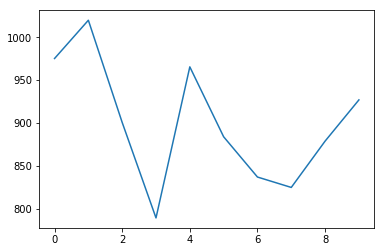

In [113]:
# let's look at the loss history!
plt.plot(loss_history)

In [118]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

[1 1 9 1 1 2 1 1 9 9 1 9 1 1 9 1 1 1 9 1 9 9 9 5 9 9 1 9 9 1 9 2 1 1 9 9 9
 1 9 9 4 1 1 9 1 9 9 9 9 1 2 1 9 0 3 9 1 9 9 3 1 1 9 9 9 1 9 1 1 9 9 9 9 9
 9 1 1 9 1 2 1 1 1 9 4 9 1 1 1 1 9 9 9 2 1 1 1 9 2 9 1 9 0 0 1 9 9 9 9 1 1
 9 9 1 1 9 2 9 1 9 9 9 9 1 9 5 1 3 1 1 9 9 9 1 9 9 1 9 9 9 2 6 1 1 1 9 1 1
 1 9 4 9 1 9 9 1 9 1 1 1 9 0 9 1 1 1 2 1 9 9 9 6 1 9 9 1 6 1 9 9 9 9 9 9 1
 9 9 9 1 1 2 1 3 1 9 1 9 9 9 9 1 9 9 3 1 1 1 1 1 1 9 1 9 1 1 9 1 9 1 4 1 1
 9 9 9 1 1 1 1 9 1 6 1 9 5 9 1 4 1 1 1 9 9 9 9 9 1 1 9 1 1 1 9 1 1 1 9 9 1
 9 1 2 5 9 1 9 1 1 9 1 9 1 1 9 1 9 9 9 9 1 9 1 5 9 1 9 1 9 0 1 1 9 9 1 3 9
 1 9 1 9 1 2 9 8 9 9 9 1 1 1 2 9 9 1 9 1 9 9 9 9 1 1 2 1 9 9 6 1 9 9 0 1 9
 2 1 9 0 1 9 2 9 1 4 9 9 9 0 9 1 2 2 0 4 9 3 9 1 9 1 9 9 9 9 1 9 2 1 1 9 1
 6 9 1 1 9 9 5 9 9 9 9 9 9 9 1 1 1 5 9 1 9 1 9 1 9 1 9 1 9 1 9 9 5 9 9 1 4
 1 9 1 2 1 9 9 4 9 1 9 9 9 1 9 9 2 1 9 9 9 9 9 9 1 1 9 2 9 9 9 9 9 9 9 5 1
 9 9 9 1 1 9 9 9 1 1 1 9 9 9 9 4 9 9 9 2 9 2 9 9 9 1 1 9 9 9 9 1 9 9 1 1 2
 1 1 1 2 5 9 9 9 1 9 1 4 

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [123]:
num_epochs = 100
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0
for rate in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=rate, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print(accuracy)
        if accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 1118.548686
Epoch 1, loss: 1035.340039
Epoch 2, loss: 807.782120
Epoch 3, loss: 766.365688
Epoch 4, loss: 743.541705
Epoch 5, loss: 1103.742235
Epoch 6, loss: 853.589827
Epoch 7, loss: 779.382973
Epoch 8, loss: 898.775587
Epoch 9, loss: 930.643169
Epoch 10, loss: 925.590677
Epoch 11, loss: 652.513269
Epoch 12, loss: 977.467383
Epoch 13, loss: 836.772607
Epoch 14, loss: 841.344878
Epoch 15, loss: 862.014726
Epoch 16, loss: 727.787484
Epoch 17, loss: 919.067006
Epoch 18, loss: 959.571040
Epoch 19, loss: 1051.463120
Epoch 20, loss: 822.812440
Epoch 21, loss: 652.004885
Epoch 22, loss: 915.136752
Epoch 23, loss: 842.198898
Epoch 24, loss: 818.530427
Epoch 25, loss: 749.284462
Epoch 26, loss: 674.285763
Epoch 27, loss: 802.951407
Epoch 28, loss: 782.990932
Epoch 29, loss: 907.349956
Epoch 30, loss: 763.873557
Epoch 31, loss: 701.041560
Epoch 32, loss: 978.391242
Epoch 33, loss: 817.081398
Epoch 34, loss: 725.160098
Epoch 35, loss: 678.753751
Epoch 36, loss: 838.833459
Epoch 3

Epoch 1, loss: 784.886670
Epoch 2, loss: 995.669626
Epoch 3, loss: 755.913700
Epoch 4, loss: 821.934528
Epoch 5, loss: 733.662120
Epoch 6, loss: 820.006118
Epoch 7, loss: 811.134455
Epoch 8, loss: 854.677276
Epoch 9, loss: 854.858373
Epoch 10, loss: 739.781173
Epoch 11, loss: 879.165402
Epoch 12, loss: 979.487132
Epoch 13, loss: 700.725036
Epoch 14, loss: 835.173119
Epoch 15, loss: 729.303263
Epoch 16, loss: 933.241283
Epoch 17, loss: 729.772761
Epoch 18, loss: 868.165138
Epoch 19, loss: 765.442878
Epoch 20, loss: 797.117686
Epoch 21, loss: 1014.441614
Epoch 22, loss: 725.655485
Epoch 23, loss: 691.321169
Epoch 24, loss: 751.358770
Epoch 25, loss: 731.207786
Epoch 26, loss: 708.853719
Epoch 27, loss: 762.042931
Epoch 28, loss: 695.648552
Epoch 29, loss: 705.219958
Epoch 30, loss: 986.674032
Epoch 31, loss: 923.468526
Epoch 32, loss: 1083.889074
Epoch 33, loss: 853.315773
Epoch 34, loss: 1000.713098
Epoch 35, loss: 784.894973
Epoch 36, loss: 835.162354
Epoch 37, loss: 734.295224
Epoch 3

Epoch 1, loss: 680.812687
Epoch 2, loss: 676.039213
Epoch 3, loss: 676.899551
Epoch 4, loss: 671.897745
Epoch 5, loss: 666.514613
Epoch 6, loss: 662.929720
Epoch 7, loss: 663.102427
Epoch 8, loss: 659.254863
Epoch 9, loss: 661.669594
Epoch 10, loss: 659.966525
Epoch 11, loss: 651.023919
Epoch 12, loss: 647.216843
Epoch 13, loss: 652.487837
Epoch 14, loss: 649.748774
Epoch 15, loss: 646.341885
Epoch 16, loss: 637.729814
Epoch 17, loss: 629.143236
Epoch 18, loss: 643.721706
Epoch 19, loss: 653.731655
Epoch 20, loss: 637.518959
Epoch 21, loss: 658.232823
Epoch 22, loss: 650.663037
Epoch 23, loss: 642.170882
Epoch 24, loss: 651.362779
Epoch 25, loss: 649.686038
Epoch 26, loss: 645.365636
Epoch 27, loss: 639.243755
Epoch 28, loss: 637.204207
Epoch 29, loss: 638.400038
Epoch 30, loss: 636.170009
Epoch 31, loss: 645.053032
Epoch 32, loss: 643.410774
Epoch 33, loss: 634.308363
Epoch 34, loss: 655.669670
Epoch 35, loss: 652.411107
Epoch 36, loss: 645.768978
Epoch 37, loss: 634.158610
Epoch 38, 

Epoch 0, loss: 689.427478
Epoch 1, loss: 689.523659
Epoch 2, loss: 688.603106
Epoch 3, loss: 687.537500
Epoch 4, loss: 687.248696
Epoch 5, loss: 687.752092
Epoch 6, loss: 685.796919
Epoch 7, loss: 685.063649
Epoch 8, loss: 685.626693
Epoch 9, loss: 683.647001
Epoch 10, loss: 686.406651
Epoch 11, loss: 682.390385
Epoch 12, loss: 682.671395
Epoch 13, loss: 681.501055
Epoch 14, loss: 679.493686
Epoch 15, loss: 680.700923
Epoch 16, loss: 679.770978
Epoch 17, loss: 682.316260
Epoch 18, loss: 683.425374
Epoch 19, loss: 679.605304
Epoch 20, loss: 681.959948
Epoch 21, loss: 673.037165
Epoch 22, loss: 676.560133
Epoch 23, loss: 674.282960
Epoch 24, loss: 677.147507
Epoch 25, loss: 675.294293
Epoch 26, loss: 674.026895
Epoch 27, loss: 676.831676
Epoch 28, loss: 678.025012
Epoch 29, loss: 676.534030
Epoch 30, loss: 675.549962
Epoch 31, loss: 668.964478
Epoch 32, loss: 669.439794
Epoch 33, loss: 675.923062
Epoch 34, loss: 674.120674
Epoch 35, loss: 669.522779
Epoch 36, loss: 670.631430
Epoch 37, l

Epoch 1, loss: 689.088999
Epoch 2, loss: 688.683094
Epoch 3, loss: 687.921441
Epoch 4, loss: 688.344215
Epoch 5, loss: 686.207102
Epoch 6, loss: 684.274505
Epoch 7, loss: 686.864653
Epoch 8, loss: 685.572976
Epoch 9, loss: 684.065905
Epoch 10, loss: 685.031117
Epoch 11, loss: 683.590102
Epoch 12, loss: 683.904662
Epoch 13, loss: 682.588084
Epoch 14, loss: 680.118146
Epoch 15, loss: 681.455945
Epoch 16, loss: 679.870757
Epoch 17, loss: 680.237980
Epoch 18, loss: 678.319881
Epoch 19, loss: 678.815001
Epoch 20, loss: 680.795998
Epoch 21, loss: 678.262943
Epoch 22, loss: 678.163458
Epoch 23, loss: 673.573552
Epoch 24, loss: 675.956670
Epoch 25, loss: 677.661766
Epoch 26, loss: 674.458387
Epoch 27, loss: 675.437141
Epoch 28, loss: 674.277885
Epoch 29, loss: 679.396785
Epoch 30, loss: 681.385937
Epoch 31, loss: 678.771120
Epoch 32, loss: 672.240334
Epoch 33, loss: 673.232455
Epoch 34, loss: 671.526533
Epoch 35, loss: 673.123328
Epoch 36, loss: 678.396419
Epoch 37, loss: 666.320331
Epoch 38, 

# Какой же точности мы добились на тестовых данных?

In [124]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

[2 2 0 2 4 2 1 1 4 1 1 2 1 2 5 1 2 4 1 1 1 1 1 1 2 1 2 2 2 1 1 2 3 5 2 4 1
 1 1 1 3 1 1 3 1 3 1 2 4 1 2 1 1 1 1 2 2 1 1 0 1 1 2 1 1 1 2 2 1 5 2 1 0 1
 4 1 1 2 1 3 2 2 8 2 3 1 1 5 3 2 3 1 1 1 6 0 2 3 1 1 1 2 3 1 8 1 2 1 3 2 3
 0 1 1 6 2 1 1 1 1 1 3 1 1 1 1 7 2 2 5 1 1 1 1 3 0 1 2 1 1 2 1 1 1 1 1 1 1
 4 2 1 3 3 2 1 5 9 1 8 2 1 2 0 1 1 3 1 1 2 7 1 1 2 3 1 1 1 2 5 6 1 1 1 1 2
 4 2 2 2 1 1 1 1 2 1 2 1 1 2 1 1 2 1 1 1 1 4 4 1 1 1 1 2 1 2 2 1 5 3 2 1 1
 1 1 2 2 1 2 2 1 5 1 1 1 2 3 2 3 1 1 1 1 1 2 1 4 3 2 1 3 1 1 1 1 1 1 7 1 2
 3 1 2 1 2 2 2 1 2 1 3 1 1 2 2 2 2 1 1 1 1 1 2 1 1 3 1 1 1 3 1 1 1 3 2 2 2
 2 1 1 1 2 1 1 1 1 1 1 2 4 2 1 1 2 1 1 1 2 2 2 1 1 4 1 1 2 2 1 1 1 2 2 2 1
 1 1 1 8 4 2 1 6 4 7 4 1 2 1 2 3 2 1 1 1 1 1 1 1 1 4 2 2 2 2 6 3 1 1 7 1 1
 2 1 3 0 3 1 1 1 2 1 3 1 6 1 6 1 2 0 1 3 1 1 1 1 1 3 2 1 1 3 1 1 2 4 1 1 1
 1 1 3 5 1 2 1 1 6 1 2 2 3 1 1 3 1 1 1 1 1 1 2 1 2 1 2 8 2 1 1 1 7 6 1 1 9
 1 1 2 5 2 2 1 2 1 1 1 5 1 2 1 2 1 1 1 1 5 1 2 2 1 1 1 5 7 1 1 1 1 3 1 1 3
 1 1 1 2 1 1 3 1 4 1 1 1 